## CPSC 8430 Fall 2024 HW_1_3c1

#### 1. Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

#### 2. Define DNN architecture (same for both models)

In [2]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 3. Utility functions

In [3]:
# Function to interpolate model weights
def interpolate_weights(model1, model2, alpha):
    model_interp = DNN()  # New model for interpolation
    params1 = list(model1.parameters())
    params2 = list(model2.parameters())
    for p1, p2, p_interp in zip(params1, params2, model_interp.parameters()):
        p_interp.data = (1 - alpha) * p1.data + alpha * p2.data
    return model_interp

# Training function
def train_model(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

#### 4. Load and prepare dataset

In [4]:
# MNIST DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data_MNIST_1_3', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data_MNIST_1_3', train=False, download=True, transform=transform)
train_loader_64 = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_1024 = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

#### 5. Model training with interpolated weights

In [7]:
# Define models and optimizers
model1 = DNN()
model2 = DNN()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train both models
print("Training model 1 with batch size 64")
train_model(model1, train_loader_64, optimizer1, criterion, epochs=10)

print("Training model 2 with batch size 1024")
train_model(model2, train_loader_1024, optimizer2, criterion, epochs=10)

# Perform interpolation between the two models
alphas = torch.linspace(-1, 2, steps=61)  # alpha = -1 to 2
train_losses = []
test_losses = []
accuracies = []

for alpha in alphas:
    # Interpolate
    model_interp = interpolate_weights(model1, model2, alpha)
    
    # Evaluate the interpolated model
    test_loss, accuracy = evaluate_model(model_interp, test_loader, criterion)
    train_loss, _ = evaluate_model(model_interp, train_loader_64, criterion)  # Use small batch for evaluation
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(f"Alpha: {alpha:.2f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

Training model 1 with batch size 64
Training model 2 with batch size 1024
Alpha: -1.00, Train Loss: 0.1057, Test Loss: 0.5962, Accuracy: 0.9780
Alpha: -0.95, Train Loss: 0.0941, Test Loss: 0.5463, Accuracy: 0.9784
Alpha: -0.90, Train Loss: 0.0835, Test Loss: 0.4996, Accuracy: 0.9787
Alpha: -0.85, Train Loss: 0.0739, Test Loss: 0.4559, Accuracy: 0.9787
Alpha: -0.80, Train Loss: 0.0652, Test Loss: 0.4152, Accuracy: 0.9789
Alpha: -0.75, Train Loss: 0.0573, Test Loss: 0.3775, Accuracy: 0.9793
Alpha: -0.70, Train Loss: 0.0506, Test Loss: 0.3423, Accuracy: 0.9796
Alpha: -0.65, Train Loss: 0.0440, Test Loss: 0.3096, Accuracy: 0.9797
Alpha: -0.60, Train Loss: 0.0385, Test Loss: 0.2795, Accuracy: 0.9799
Alpha: -0.55, Train Loss: 0.0337, Test Loss: 0.2516, Accuracy: 0.9804
Alpha: -0.50, Train Loss: 0.0293, Test Loss: 0.2260, Accuracy: 0.9808
Alpha: -0.45, Train Loss: 0.0256, Test Loss: 0.2024, Accuracy: 0.9809
Alpha: -0.40, Train Loss: 0.0225, Test Loss: 0.1809, Accuracy: 0.9813
Alpha: -0.35, Tr

#### 6. Plotting

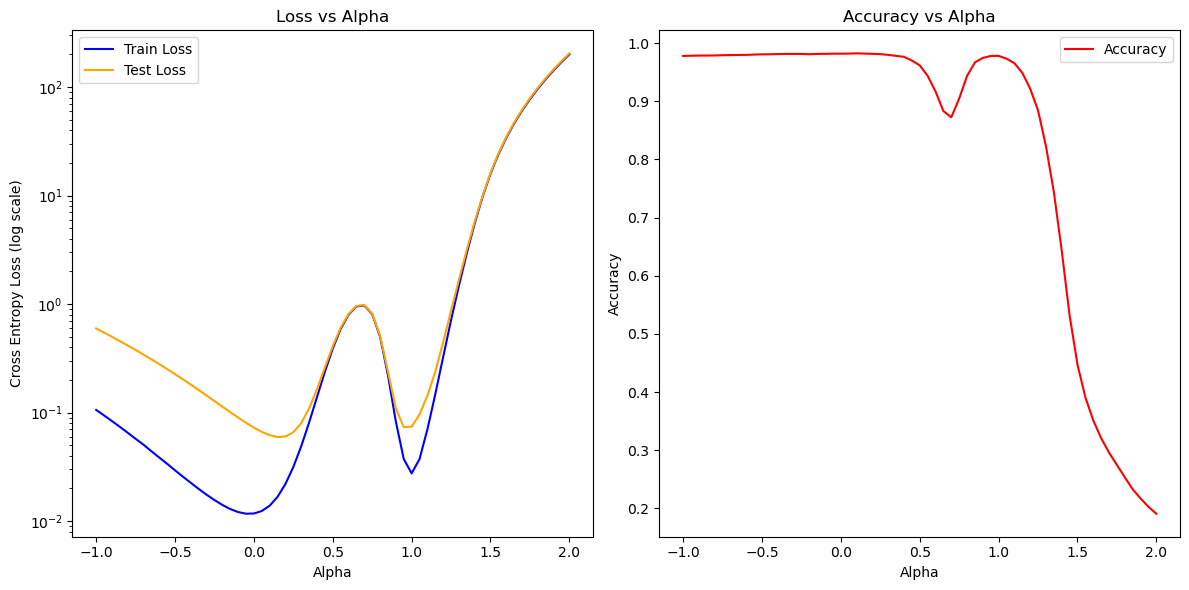

In [9]:
# Plot Loss vs Alpha
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, train_losses, label="Train Loss", color='blue')
plt.plot(alphas, test_losses, label="Test Loss", color='orange')
plt.xlabel('Alpha')
plt.ylabel('Cross Entropy Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.title('Loss vs Alpha')

# Plot Accuracy vs Alpha
plt.subplot(1, 2, 2)
plt.plot(alphas, accuracies, label="Accuracy", color='red')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Alpha')

plt.tight_layout()
plt.show()